# Tarea 5 : Seq2Seq a Nivel Palabra

## Aprendizaje Automático I

### Esteban Reyes Saldaña

**Resumen**

En esta tarea se utilizó el modelo seq2seq para la traducción de oraciones de inglés a español. Dicho modelo es un método de traducción máquina basado en redes neuronales recurrentes que usa en la coficicación de secuencias de entrada (idioma de entrada) y decodificación de una secuencia de salida (idioma objetivo). 

Se utilizó el curpus Parallelo de Opus descrito a continuación y la codificación se realizó a nivel de palabras. Cada palabra se codificó utilizando matrices de embeddings pre entrenadas.

Finalmente se implementó un modelo de traducción utilizando seq2seq.

Resumen

# Descarga de Corpus

Se utilizará la base de datos con frases de inglés y su traducción en español ''Books'' de Open Parallel corpUS (OPUS).
Artículo explicando el proyecto opus y su uso http://www.lrec-conf.org/proceedings/lrec2012/pdf/463_Paper.pdf.

La página del proyecto esta en https://opus.nlpl.eu. Para ver los parallel corpora de English y Spanish seleccione :

Search download resources: << en(English) >><< es(Spanish) >><<
all >>.

```
Search download resources: << en(English) >><< es(Spanish) >><< all >>.
```





In [ ]:
pip install OpusTools

     |████████████████████████████████| 112kB 5.1MB/s 


In [ ]:
import opustools as opus

In [ ]:
dir = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/'
op = opus.OpusGet(source = 'en', target = 'es', directory = 'Books', download_dir = dir, preprocess = 'xml')

op.get_files()

In [ ]:
dir_opus = '/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/'

op_read = opus.OpusRead(directory                = 'Books',  
                        source                   = 'en', 
                        target                   = 'es', 
                        release                  = 'latest', 
                        download_dir             = dir_opus, 
                        preprocess               = 'xml',
                        write                    = 'text.txt',
                        write_mode               = 'normal', 
                        suppress_prompts         = True,
                        leave_non_alignments_out = True, 
                        verbose                  = True)

Reading alignment file No alignment file "/projappl/nlpl/data/OPUS/Books/latest/xml/en-es.xml.gz" or "/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_en-es.xml.gz" found
The following files are available for downloading:

 840 KB https://object.pouta.csc.fi/OPUS-Books/v1/xml/en-es.xml.gz
  71 MB https://object.pouta.csc.fi/OPUS-Books/v1/xml/en.zip
  22 MB https://object.pouta.csc.fi/OPUS-Books/v1/xml/es.zip

  94 MB Total size
/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_en-es.xml.gz ... 100% of 840 KB
/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_en.zip ... 100% of 71 MB
/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_es.zip ... 100% of 22 MB
"/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_en-es.xml.gz"


In [ ]:
op_read.printPairs()

Opening zip archive "/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_en.zip" ... Done
Opening zip archive "/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/Books_latest_xml_es.zip" ... Done
Reading src_file "Books/xml/en/Austen_Jane-Sense_and_Sensibility.xml"
Reading trg_file "Books/xml/es/Austen_Jane-Sense_and_Sensibility.xml"
Reading src_file "Books/xml/en/Bronte_Charlotte-Jane_Eyre.xml"
Reading trg_file "Books/xml/es/Bronte_Charlotte-Jane_Eyre.xml"
Reading src_file "Books/xml/en/Carroll_Lewis-Alice_in_wonderland.xml"
Reading trg_file "Books/xml/es/Carroll_Lewis-Alice_in_wonderland.xml"
Reading src_file "Books/xml/en/Cervantes_Miguel-Don_Quijote.xml"
Reading trg_file "Books/xml/es/Cervantes_Miguel-Don_Quijote.xml"
Reading src_file "Books/xml/en/Defoe_Daniel-Robinson_Crusoe.xml"
Reading trg_file "Books/xml/es/Defoe_Daniel-Robinson_Crusoe.xml"
Reading src_file "Books/xml/en/Doyle_Arthur_Conan-Adventures_of_Sherlock_Holmes.xml"
Reading

# Lectura de los datos

In [1]:
from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

num_samples = 120000  #20000  # número de muestran con las cuales entrenar

In [2]:
# archivo con sentencias inglés-español
data_path = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/en_es.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

lines[:30]

['',
 '# en/Austen_Jane-Sense_and_Sensibility.xml.gz',
 '# es/Austen_Jane-Sense_and_Sensibility.xml.gz',
 '',
 '================================',
 '(src)="s1">Source : Project GutenbergAudiobook available here',
 '(trg)="s1">Source : Wikisource & librodot.com',
 '================================',
 '(src)="s2">Sense and Sensibility',
 '(trg)="s2">SENTIDO Y SENSIBILIDAD',
 '================================',
 '(src)="s3">Jane Austen',
 '(trg)="s3">JANE AUSTEN',
 '================================',
 '(src)="s4">CHAPTER 1',
 '(trg)="s4">CAPITULO I',
 '================================',
 '(src)="s5.0">The family of Dashwood had long been settled in Sussex .',
 '(trg)="s5.0">La familia Dashwood llevaba largo tiempo afincada en Sussex .',
 '================================',
 '(src)="s5.1">Their estate was large , and their residence was at Norland Park , in the centre of their property , where , for many generations , they had lived in so respectable a manner as to engage the general good 

In [3]:
# Quito primeras líneas
lines = lines[7:]

Los pares de oraciones están separadas por el string 
```
'================================'
```
Así que las separamos por grupos. Notemos que hay grupos de tamaño distinto de dos, por ejemplo
```
'================================'
(src)="s5.3">But her death , which happened ten years before his own , produced a great alteration in his home ; for to supply her loss , he invited and received into his house the family of his nephew Mr. Henry Dashwood , the legal inheritor of the Norland estate , and the person to whom he intended to bequeath it .
(trg)="s5.3">Pero la muerte de ella , ocurrida diez años antes que la suya , produjo grandes alteraciones en su hogar .
(trg)="s5.4">Para compensar tal pérdida , invitó y recibió en su casa a la familia de su sobrino , el señor Henry Dashwood , el legítimo heredero de la finca Norland y la persona a quien se proponía dejarla en su testamento .
'================================'
```
las cuales descartaremos. 


# Preprocesamiento

In [4]:
import nltk
from nltk import FreqDist

tk = nltk.RegexpTokenizer(r"\w+")

In [5]:
pairs           = [] # Pares [src, tg]
pair            = [] # Par temporal
total_sentences = 0

for line in lines :
  # Agrego a par mientras pertenezca al mismo grupo
  if line != '================================' :
    pair.append(line)
  else :
    # Actualizo contador de oraciones
    total_sentences += 1
    # Solo agrego los grupos [src,tg]
    if len(pair) == 2 and len(pair[0]) > 1 and len(pair[1]) > 1 :
      pairs.append(pair)
    # Preparo para siguiente oración
    pair = []

print('Número total de oraciones    : ', total_sentences)
print('Número de oraciones filtradas: ', len(pairs))

Número total de oraciones    :  97116
Número de oraciones filtradas:  73858


**Ejemplo**

In [6]:
[sentence.lower().split('>') for sentence in pairs[1]]

[['(src)="s3"', 'jane austen'], ['(trg)="s3"', 'jane austen']]

Se obtienen tokens finales quitando '(src)="s3"' y '(trg)="s3"'

In [7]:
final_pairs = []

for group in pairs :
  tmp  = [sentence.lower().split('>') for sentence in group]
  if len(tmp[0]) > 1 and len(tmp[1]) > 1 :
    pair = [tmp[0][1], tmp[1][1]]
    final_pairs.append(pair)

In [8]:
def rare_char(char_) :
  value = not char_.isnumeric()     \
          and char_.find('.') == -1 \
          and char_.find('º') == -1 \
          and char_.find(',') == -1 \
          and char_.find('_') == -1 \
          and char_.find(':') == -1 \
          and char_.find('=') == -1 \

  return value

In [9]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

input_sentences_tokens  = []
target_sentences_tokens = []

for line in final_pairs[: min(num_samples, len(final_pairs))]:
  # Guarda oración tokenizada
  src_sentence = []
  trg_sentence = []
  
  # Separo source y target
  input_text, target_text = line  
    
  input_texts.append(input_text.lower())
  target_texts.append(target_text.lower())
  # Token de inicio de oración
  src_sentence.append('<s>')
  for word in tk.tokenize(input_text.lower()):
    # Agrego si no es basura
    if rare_char(word) :
      # Agrego a oración tokenizada
      src_sentence.append(word)
      if word not in input_characters:
        input_characters.add(word)
  # Token de fin de oración
  src_sentence.append('</s>') 

  # Token de inicio de oración
  trg_sentence.append('<s>')
  for word in tk.tokenize(target_text.lower()):
    # Agrego si no es basura
    if rare_char(word) :
      # Agrego a oración tokenizada
      trg_sentence.append(word)
      if word not in target_characters:
        target_characters.add(word)
  # Token de fin de oración
  trg_sentence.append('</s>') 
  # Agrego a oraciones tokenizadas
  input_sentences_tokens.append(src_sentence)
  target_sentences_tokens.append(trg_sentence)
    
print(f'Conjunto (Set) de caracteres que conforman las sentencias de entrada: \n{input_characters} \n')
    
print(f'Conjunto (Set) de caracteres que conforman las sentencias objetivo: \n{target_characters}')

Conjunto (Set) de caracteres que conforman las sentencias de entrada: 
{'rarities', 'accent', 'troitsa', 'rough', 'shrugged', 'jobs', 'fore', 'repentest', 'preliminarily', 'fermais', 'retenez', 'jupiter', 'gripe', 'gull', 'unprepared', 'enlivened', 'deepden', 'crack', 'drawn', 'et', 'farrier', 'occupants', 'outstrip', 'incredible', 'ulmaceae', 'monitored', 'husbandry', 'javelins', 'endeavoring', 'local', 'warriors', 'thoughts', 'empties', 'tact', 'eminence', 'cleave', 'threatens', 'mulling', 'quays', 'brightness', 'conceives', 'rampart', 'tropical', 'watertight', 'infanterie', 'princetown', 'guiomar', 'mener', 'faits', 'attendant', 'monomaniac', 'lover', 'inserting', 'commentait', 'rousing', 'jason', 'eligible', 'especially', 'drover', 'heliotropes', 'ailed', 'arrangement', 'unnoticed', 'chastise', 'swath', 'coure', 'tattered', 'lumber', 'brimmed', 'anyhow', 'initiated', 'summers', 'butterfish', 'surprise', 'malignant', 'flocking', 'commissioned', 'cloister', 'intractable', 'thornfield

In [10]:
print(sorted(list(target_characters)))

['16a', '221b', 'a', 'a1', 'abad', 'abadejo', 'abadejos', 'abades', 'abadesa', 'abadía', 'abajan', 'abajarse', 'abajo', 'abajó', 'abalanzaba', 'abalanzamos', 'abalanzarnos', 'abalanzarse', 'abalanzándose', 'abalanzáronse', 'abalanzó', 'abalazándose', 'abalorio', 'abalorios', 'abalánzase', 'abanderado', 'abandona', 'abandonaba', 'abandonaban', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abandonamos', 'abandonan', 'abandonando', 'abandonar', 'abandonara', 'abandonaran', 'abandonaremos', 'abandonarla', 'abandonarle', 'abandonarlo', 'abandonarme', 'abandonarnos', 'abandonaron', 'abandonarse', 'abandonarte', 'abandonará', 'abandonarás', 'abandonaré', 'abandonaréis', 'abandonaría', 'abandonarían', 'abandonas', 'abandonase', 'abandonasen', 'abandonaste', 'abandone', 'abandono', 'abandonáis', 'abandonándose', 'abandonáron', 'abandoné', 'abandonéis', 'abandonó', 'abandóname', 'abanico', 'abanicos', 'abanicándose', 'abaniqué', 'abarcaba', 'abarcaban', 'abarcar', 'abarcarse', 'abar

In [11]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
print(f'Número de palabras en el idioma fuente  : {num_encoder_tokens}')
print(f'Número de palabras en el idioma objetivo: {num_decoder_tokens}')

Número de palabras en el idioma fuente  : 35544
Número de palabras en el idioma objetivo: 56410


In [12]:
max_encoder_seq_length = max([len(tk_sentence) for tk_sentence in input_sentences_tokens])
max_decoder_seq_length = max([len(tk_sentence) for tk_sentence in target_sentences_tokens])

print('Longitud máxima de sentencia en el idioma fuente:', max_encoder_seq_length)
print('Longitud máxima de sentencia en el idioma destino:', max_decoder_seq_length)

Longitud máxima de sentencia en el idioma fuente: 307
Longitud máxima de sentencia en el idioma destino: 274


In [13]:
input_token_index  = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

## Filtrado por tamaño de oración

Nuestros encoders tendrá dimensiones `(num_oraciones, tam_max_oracion, dim_emb)`. Si la longitud máxima del tamaño de oraciones es muy grande, la cantidad de memoria RAM requerida será muy grande. Así que nos quedaremos con aquellas oraciones que tengan longitud menor a $10$.

In [61]:
max_long_sentence = 20
input_tokens      = []
target_tokens     = []

In [62]:
for i in range(len(input_sentences_tokens)) :
  # Reviso que oración tenga contenido
  if len(input_sentences_tokens[i]) > 1 and len(target_sentences_tokens[i]) > 1 :
    # FIltro por tamaño
    if len(input_sentences_tokens[i]) < max_long_sentence and len(target_sentences_tokens[i]) < max_long_sentence :
      input_tokens.append(input_sentences_tokens[i])
      target_tokens.append(target_sentences_tokens[i])

In [63]:
print('Total de oraciones en idioma fuente:    ', len(input_tokens))
print('Total de oraciones en el idioma destino:', len(target_tokens))

Total de oraciones en idioma fuente:     39237
Total de oraciones en el idioma destino: 39237


In [64]:
max_encoder_seq_length = max([len(tk_sentence) for tk_sentence in input_tokens])
max_decoder_seq_length = max([len(tk_sentence) for tk_sentence in target_tokens])

print('Longitud máxima de sentencia en el idioma fuente:', max_encoder_seq_length)
print('Longitud máxima de sentencia en el idioma destino:', max_decoder_seq_length)

Longitud máxima de sentencia en el idioma fuente: 19
Longitud máxima de sentencia en el idioma destino: 19


# Contrucción de diccionarios

In [65]:
def sortFreqDisct(freq_dist) :
  freq_dict = dict(freq_dist)
  return sorted(freq_dict, key = freq_dict.get, reverse = True)

def get_vocab(sentences, vocab_max) :
  freq_dist = FreqDist([word.lower() for sentence in sentences for word in sentence])
  sorted_words = sortFreqDisct(freq_dist)[:vocab_max - 1]
  return set(sorted_words)

In [66]:
def mask(word, vocab) :
  if word in vocab :
    return word 
  else :
    return '<unk>'

def mask_sentences (sentences, vocab) :
  updated_sentences = []
  for sentence in sentences :
    sentence_ = [mask(word, vocab) for word in sentence]
    updated_sentences.append(sentence_)

  return updated_sentences

In [67]:
vocab_max = 50000

input_vocab  = get_vocab(input_tokens, vocab_max)
target_vocab = get_vocab(target_tokens, vocab_max)

In [68]:
input_tokens  = mask_sentences(input_tokens,  input_vocab)
target_tokens = mask_sentences(target_tokens, target_vocab)

# Word2Vec

## Matriz de Embeddings para idioma español

In [69]:
import pandas as pd

In [70]:
word2vec_dir = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Lenguaje Natural/T05/word2vec_col.txt'

In [71]:
def get_word2vec_matrix(dir) :
  # read txt
  full_txt = pd.read_csv(word2vec_dir, sep = '\r\n', engine = 'python', header = None).loc[:,0].values.tolist()
  # d[0] for total words, d[1] for embeddings dimension
  dimensions = np.array(full_txt[0].split(), dtype = np.int)
  full_txt = full_txt[1:]
  word2vec = dict()
  for i in range(dimensions[0]) :
    embedding = full_txt[i].split(' ')
    # Add word to dictionary
    tmp = np.array(embedding[1:], dtype = np.float32)
    word2vec[embedding[0]] = tmp / np.linalg.norm(tmp)
  return word2vec

In [72]:
embeddings_es = get_word2vec_matrix(word2vec_dir)

In [73]:
emb_dim_es = 100

In [74]:
# Tokens especiales
embeddings_es['<s>'] = np.random.uniform(-1, 1, size = emb_dim_es)
embeddings_es['</s>'] = np.random.uniform(-1, 1, size = emb_dim_es)
embeddings_es['<unk>'] = np.random.uniform(-1, 1, size = emb_dim_es)

Ejemplo

In [75]:
embeddings_es['de']

array([-0.06227244,  0.05491327, -0.08660728, -0.07454524, -0.00845671,
        0.19365184, -0.00457845, -0.00481063, -0.12052324, -0.13103266,
       -0.03577316, -0.00358368, -0.04511498, -0.03080439, -0.09759846,
       -0.02328567, -0.0876931 ,  0.03986555,  0.21373722, -0.22103085,
        0.0469463 ,  0.04064888,  0.1449794 ,  0.0908632 ,  0.00644403,
        0.12353874,  0.10990263,  0.12422122, -0.11138327,  0.01031766,
       -0.03905134, -0.09927936, -0.06854881,  0.06591181,  0.01286393,
        0.14918448,  0.05960509, -0.1555246 ,  0.15767695,  0.04409104,
       -0.02095053, -0.02222395, -0.18082964,  0.00960965, -0.04264187,
       -0.00436519, -0.21267128,  0.11290803,  0.16788852,  0.03868821,
        0.14265218, -0.08718123,  0.16752987, -0.05249764, -0.07064885,
        0.01513694, -0.04160739, -0.08671251,  0.1135234 ,  0.00166932,
        0.14271496, -0.24743618,  0.02356641,  0.10021024, -0.07299385,
       -0.04328756, -0.14534715,  0.02084717,  0.08575848, -0.05

## Matriz de Embeddings para Inglés

La matriz de embeddings en inglés se tomó de http://vectors.nlpl.eu/repository/20/0.zip



```
--2021-04-15 03:19:36--  http://vectors.nlpl.eu/repository/20/0.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344050746 (328M) [application/zip]
Saving to: ‘0.zip’

0.zip               100%[===================>] 328.11M  23.3MB/s    in 15s     

2021-04-15 03:19:52 (22.1 MB/s) - ‘0.zip’ saved [344050746/344050746]
```



In [76]:
word2vec_dir = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea5/model.txt'

In [77]:
def get_word2vec_matrix(dir) :
  # read txt
  full_txt = pd.read_csv(word2vec_dir, sep = '\r\n', engine = 'python', header = None).loc[:,0].values.tolist()
  # d[0] for total words, d[1] for embeddings dimension
  dimensions = np.array(full_txt[0].split(), dtype = np.int)
  full_txt = full_txt[1:]
  word2vec = dict()
  for i in range(dimensions[0]) :
    embedding = full_txt[i].split(' ')
    # Add word to dictionary
    word2vec[embedding[0].split('_')[0]] = np.array(embedding[1:], dtype = np.float32)
  return word2vec

In [78]:
embeddings_en = get_word2vec_matrix(word2vec_dir)

In [79]:
emb_dim_en = 300

In [80]:
# Tokens especiales
embeddings_en['<s>'] = np.random.uniform(-1, 1, size = emb_dim_en)
embeddings_en['</s>'] = np.random.uniform(-1, 1, size = emb_dim_en)
embeddings_en['<unk>'] = np.random.uniform(-1, 1, size = emb_dim_en)

In [81]:
embeddings_en['know']

array([-0.009748,  0.144799,  0.120451,  0.02399 , -0.167805,  0.039619,
       -0.033026, -0.022363,  0.005768, -0.082646, -0.117366,  0.058159,
       -0.00092 ,  0.002299, -0.028391, -0.020692,  0.044759,  0.020757,
       -0.060559,  0.094923, -0.005458,  0.063785,  0.064187, -0.014302,
        0.073799, -0.078597,  0.043564, -0.088903,  0.006734,  0.022817,
        0.028747,  0.01205 , -0.066195,  0.024624,  0.007043, -0.020038,
       -0.045174,  0.012632,  0.008278, -0.125123,  0.042678,  0.028995,
        0.064559, -0.111835,  0.012511, -0.050502,  0.023236, -0.015012,
       -0.037426,  0.082342, -0.065375, -0.099088,  0.002032,  0.063476,
        0.032742,  0.05466 , -0.01688 , -0.075513,  0.053302,  0.038384,
       -0.039656, -0.134608,  0.142785, -0.043055, -0.042197,  0.02116 ,
        0.027784,  0.026957,  0.108325, -0.038108, -0.003571, -0.011024,
       -0.046932, -0.036492, -0.068892, -0.025117, -0.137043,  0.001841,
       -0.053895, -0.116115, -0.010605, -0.079892, 

Se usará la librería ```models.Word2Vec``` que implementa una familia de algoritmos Word2Vec usando rutinas de C altamente optimizadas, data streaming e interfaces de Pythonic. La documentación está disponible en
 https://radimrehurek.com/gensim/models/word2vec.html

# Matrices de Codificación

In [108]:
encoder_input_data = np.zeros((len(input_tokens), 
                               max_encoder_seq_length, 
                               emb_dim_en), dtype = np.float32)

In [109]:
decoder_input_data = np.zeros((len(input_tokens), 
                               max_decoder_seq_length, 
                               emb_dim_es), dtype = np.float32)

In [110]:
decoder_target_data = np.zeros((len(input_tokens), 
                                max_decoder_seq_length, 
                                emb_dim_es), dtype = np.float32)

### Codificación de cada sentecia de entrada y destino.

In [85]:
for i, (input_text, target_text) in enumerate(zip(input_tokens, target_tokens)):
  # Guardo tamaños para padding
  len_input  = (len(input_text))
  len_target = (len(target_text))
  # Hago padding al frente
  encoder_input_data[i, : ] = embeddings_en['<unk>']

  # codificación de la secuencia de entrada
  for t, word in enumerate(input_text):
    if word in embeddings_en :
      encoder_input_data[i, -t -1] = embeddings_en[word]
    # De otro modo agrego como token desconocido
    else :
      encoder_input_data[i, -t -1] = embeddings_en['<unk>']
  

  # Hago padding enfrente
  decoder_input_data[i,  : ] = embeddings_es['<unk>']
  decoder_target_data[i, : ] = embeddings_es['<unk>']

  # codificación de la secuencia de salida
  for t, word in enumerate(target_text):
    # Reviso si está en diccionario de embeddins
    if word in embeddings_es :
      decoder_input_data[i, t + max_decoder_seq_length - len_target] = embeddings_es[word]
    # De otro modo agrego como token desconocido
    else :
      decoder_input_data[i, t + max_decoder_seq_length - len_target] = embeddings_es['<unk>']
    if t > 0:
      # con ello se "adelanta", un paso en el tiempo a `decoder_input_data`
      if word in embeddings_es :
        decoder_target_data[i, t - 1 + max_decoder_seq_length - len_target] = embeddings_es[word]
      # De otro modo agrego como token desconocido
      else :
        decoder_target_data[i, t - 1 + max_decoder_seq_length - len_target] = embeddings_es['<unk>']


In [86]:
import matplotlib.pyplot as plt
join_sentence = ' '.join(input_text)
print(f'Última secuencia leida en el idioma fuente: {join_sentence}')

Última secuencia leida en el idioma fuente: <s> excellently observed answered candide but let us cultivate our garden </s>


Última secuencia leida en el idioma fuente: <s> bien dice vm respondió candido pero es menester labrar nuestra huerta </s>


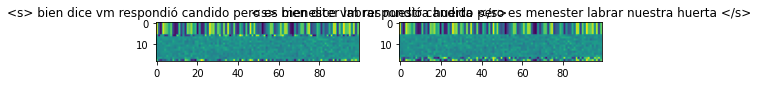

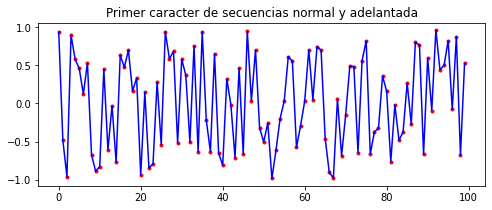

In [87]:
import matplotlib.pyplot as plt

join_sentence = ' '.join(target_text)

print(f'Última secuencia leida en el idioma fuente: {join_sentence}')
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(decoder_input_data[-1])
plt.title(join_sentence)
plt.subplot(122)
plt.imshow(decoder_target_data[-1])
plt.title(join_sentence)
plt.show()

plt.figure(figsize=(8,3))
plt.plot(decoder_input_data[-1][1], '.r')
plt.plot(decoder_target_data[-1][0], 'b')
plt.title('Primer caracter de secuencias normal y adelantada')
plt.show()

# Modelo seq2seq con LSTM. Modo Entrenamiento

A diferencia de las redes secuenciales donde cada entrada es procesada en forma independioente, sin tomar en cuenta la histora de datos procesados, una red recurrente utiliza información del procesamiento de datos pasados para calcular su respuesta a un nuevo dato.



In [88]:
batch_size  = 16    
epochs      = 20  
latent_dim  = 1024    # Dimension del espacio latente

In [89]:
encoder_inputs = Input(shape = (None, emb_dim_en))
encoder_o, encoder_h, encoder_c = LSTM(units = latent_dim, return_state = True)(encoder_inputs)

# Descartamos la salida y conservamos los estados internos 
encoder_states = [encoder_h, encoder_c]

In [90]:
print(encoder_inputs.shape)
print(encoder_o.shape, encoder_h.shape, encoder_c.shape)

(None, None, 300)
(None, 1024) (None, 1024) (None, 1024)


### Decodificador

**Decodificador (Decoder)**

Puntos a considerar para implementar el decodificador:

* Para el decodificador usaremos de nuevo una LSTM.

* La entrada del decodificador es la salida del decodificador.

* El estado inicial (de la primera etapa) del decodificador estará dado por los estados internos del decodificador

* El decodificador debe regresar la secuencia completa.

* Usaremos el estado interno del la última etapa del decodificador para la inferencia.

* Se agrega una capa densa a la salida para obtener la secuencia codificada (relajación de hot-dense en forma de probabilidad).

In [91]:
# la entrada son secuencias de caracteres del idioma destino, codificados en one-hot 
decoder_inputs  = Input(shape=(None, emb_dim_es))

layer_lstm      = LSTM(units = latent_dim, return_sequences = True, return_state     = True)
decoder_O, _, _ = layer_lstm(decoder_inputs, initial_state=encoder_states)

layer_dense     = Dense(units = emb_dim_es, activation = 'softmax')
decoder_outputs = layer_dense(decoder_O)

In [92]:
print(decoder_inputs.shape, decoder_O.shape, encoder_states[0].shape, encoder_states[1].shape)
print(decoder_outputs.shape)

(None, None, 100) (None, None, 1024) (None, 1024) (None, 1024)
(None, None, 100)


### Modelo Seq2Seq

Combina el desde la entrada del codificador y hasta la salida del decodificador.

In [93]:
model = Model(inputs  = [encoder_inputs,   # secuencia en idioma fuente
                         decoder_inputs],  # secuencia en idioma destino 
              outputs = decoder_outputs)   # predicción adelantada en idioma 
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1024), (None 5427200     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 1024), 4608000     input_6[0][0]                    
                                                                 lstm_2[0][1]               

### Entrenamiento (training)

In [94]:
model.compile(optimizer = 'rmsprop', 
              loss      = 'mean_squared_error',
              metrics   = ['accuracy'])

In [95]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

my_callbacks = [EarlyStopping(patience = 2),
                ModelCheckpoint(filepath = 'seq2seq_en2sp.{epoch:04d}-{val_loss:.2f}.h5'),
                TensorBoard(log_dir = './logs'),]

In [96]:
model.fit(x                = [encoder_input_data,       # secuencia en idioma fuente
                              decoder_input_data],      # sec. en idioma destino 
          y                = decoder_target_data,       # sec. en idioma destino adelantada 1 caracter 
          batch_size       = batch_size,
          epochs           = epochs,
          shuffle          = True,    
          validation_split = 0.2,
          callbacks        = my_callbacks)

model.save('seq2seq_en_es.h5')

Epoch 1/20
1962/1962 [==============================] - 51s 24ms/step - loss: 0.2021 - accuracy: 0.2125 - val_loss: 0.1892 - val_accuracy: 0.5122
Epoch 2/20
1962/1962 [==============================] - 46s 23ms/step - loss: 0.2008 - accuracy: 0.4035 - val_loss: 0.1892 - val_accuracy: 0.5226
Epoch 3/20
1962/1962 [==============================] - 46s 23ms/step - loss: 0.2012 - accuracy: 0.4316 - val_loss: 0.1892 - val_accuracy: 0.4935
Epoch 4/20
1962/1962 [==============================] - 46s 23ms/step - loss: 0.2020 - accuracy: 0.4763 - val_loss: 0.1892 - val_accuracy: 0.5329
Epoch 5/20
1962/1962 [==============================] - 46s 23ms/step - loss: 0.2000 - accuracy: 0.4924 - val_loss: 0.1892 - val_accuracy: 0.5341
Epoch 6/20
1962/1962 [==============================] - 46s 23ms/step - loss: 0.2003 - accuracy: 0.5184 - val_loss: 0.1892 - val_accuracy: 0.4964
Epoch 7/20
1962/1962 [==============================] - 46s 23ms/step - loss: 0.2004 - accuracy: 0.5191 - val_loss: 0.1891 -

# Inferencia

### Diccionarios de orden

In [97]:
## Diccionarios invertidos español
def sortfreqDict(freqdict):
  aux = [(freqdict[key], key) for key in freqdict]
  aux.sort(key = lambda elem: (elem[0], elem[1]), reverse = True)
  return aux

def get_dict_order(sentences) :
  w2id = dict()
  id2w = dict()
  corpus_palabras = [word for sentence in sentences for word in sentence]
  freq_dist = FreqDist(corpus_palabras)

  V = sortfreqDict(freq_dist)

  # Creo diccionario de vocabulario
  count = 0
  for wigth, word in V:
    w2id[word]  = count
    id2w[count] = word

    count += 1

  print('Total de palabras: ', count)

  return w2id, id2w

In [98]:
def build_embedding_matrix(dict_embeddings, w2id) :
  count = 0
  embedding_matrix = []
  for word, i in w2id.items() :
    if word in dict_embeddings :
      embedding_matrix.append(dict_embeddings[word])
    else :
      embedding_matrix.append(dict_embeddings['<unk>'])
  return embedding_matrix

In [99]:
w2id_es, id2w_es = get_dict_order(target_tokens)
es_matrix        = build_embedding_matrix(embeddings_es, w2id_es)

Total de palabras:  25088


### Predicción

Hemos entrenado el modelo Seq2seq, sin embargo no pueed cser usado directamente para hacer inferencia. Para empezar, usamos como datos de entrada (decoder_input_data) la secuencia en el idioma destino, está no estará diponible en la inferencia.

Los puntos a considerar son:

1. El Codificador permanece sin cambios

In [100]:
encoder_model = Model(encoder_inputs, encoder_states)

2. El Decodificador

La forma de transformar una secuencia es codificando la información semántica en forma completa por el codificador y luego pasar los estados ocultos de salida al decodificador para que los decodifique caracter por caracter generando asi la nueva secuencia.



*   Ahora si usamos los estados que resultan de la red LSTM (decoder_H, decoder_C ), pues se usarán para pasar de un caracter al siguiente.
*   El decodificador tienen como estado inicial los estados de salida del codificador.

Entradas al decodificador



Note que usaremos la capa layer_lstm que ha sido entrenada previamente.

In [101]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [102]:
decoder_O, state_H, state_C = layer_lstm(decoder_inputs, 
                                         initial_state = decoder_states_inputs)

Igual pasa con la densa de decodificación.

In [103]:
decoder_outputs = layer_dense(decoder_O)

Este nuevo modelo lo usaremos para traducir secuencias, no para entrenar. Es necesario que definamos en inputs y en outputs la forma correcta en que el decodificador recibirá las entradas.



*   Como entrada una tensor para cuyo modelo (tamaño) nos sirve de entrada decoder_inputs y los estados de salida del encoder.
*   Como salida produce una secuencia predicha adelantada y sus estados de salida.


In [104]:
decoder_model = Model(inputs = [decoder_inputs] + decoder_states_inputs,  # concatenación de listas
                      outputs = [decoder_outputs] + [state_H, state_C])

In [105]:
import torch
import random

In [106]:
def decode_sequence(input_seq, max_long):
    # -------------------------------------------------------------------------------
    # Codifica toda la secuencia de entrada en vectores de estados [state_c, state_h]
    # -------------------------------------------------------------------------------
    states_value = encoder_model.predict(input_seq)
    # -------------------------------------------------------------------------------
    # Decodificamos `state_values` caracter por caracter a la secuencia de salida
    # -------------------------------------------------------------------------------
    # Genera una secuencia resultante vacia de longitud 1 (adelantada)
    target_seq = np.zeros((1, 1, emb_dim_es))
    # target_seq = np.zeros((1, 1, num_decoder_tokens))

    # Llena la primera secuencia con el caracter de inicio de secuencia
    target_seq[0, 0] = embeddings_es['<s>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        # Predice un caracter a la vez para la secuencia de salida
        output_token, state_H, state_C = decoder_model.predict([target_seq]+ states_value)

        # Obtengo vector de salida
        sampled_token = output_token[0, -1]
        # Calculo distancias usando torch
        dists = torch.norm(torch.from_numpy(np.array(es_matrix)) - sampled_token, dim = 1).detach()  # compute distances to all words
        lst   = sorted(enumerate(dists.numpy()), key = lambda x: x[1])   # sort by distance
        # Me quedo con las cinco más cercanas
        index = []
        for idx, difference in lst[1:5+1] :
          index.append(idx)
        # Tomo una de manera aleatoria
        sampled_token_index = random.choice(index)

        sampled_char        = id2w_es[sampled_token_index]
        decoded_sentence    += ' ' + sampled_char

        # Fin de procesamiento de secuencia ('\n' o se alcanzó la longitud máxima)
        if (sampled_char == '<\s>' or len(decoded_sentence) > max_long + 2):
            stop_condition = True

        # Actualiza la entrada al decodificador para la siguiente prediccion 
        target_seq = np.zeros((1, 1, emb_dim_es))
        target_seq[0, 0] = es_matrix[sampled_token_index]

        # actualiza estados
        states_value = [state_H, state_C]

    return decoded_sentence

In [107]:
print('Sentencia en Inglés --> Traducción por la red Seq2Seq al Español')

 # Decodifica una por una de secuencias del conjunto de entrenamiento
for seq_index in range(50):
    
    # secuencia codificada en one-hot
    input_seq        = encoder_input_data[seq_index: seq_index + 1]
    
    # transformada por el modelo y decodificada caracter a caracter.
    decoded_sentence = decode_sequence(input_seq, len(' '.join(input_tokens[seq_index])) )
    
    # despliega resultados
    print(' '.join(input_tokens[seq_index]), ' --> ', decoded_sentence)

Sentencia en Inglés --> Traducción por la red Seq2Seq al Español
<s> sense and sensibility </s>  -->   ya pero lo ni ni pero si algo ni
<s> jane austen </s>  -->   por qué porque pero si
<s> chapter </s>  -->   lo entendí que lo sino
<s> the family of dashwood had long been settled in sussex </s>  -->   porque algo sino porque pero porque porque lo he mencionado por eso
<s> his attachment to them all increased </s>  -->   lo ni por si porque porque si pero solo lo no entiendo
<s> by his own marriage likewise which happened soon afterwards he added to his wealth </s>  -->   solo pero porque algo sino ni porque solo sólo sino sólo solo y por no eso dicen interrupción
<s> but the fortune which had been so tardy in coming was his only one twelvemonth </s>  -->   porque creo porque porque creo porque porque alguien sino porque creo lo que no no pienso
<s> he then really thought himself equal to it </s>  -->   porque lo entendí si lo ni solo pero solo por eso si eso
<s> marianne s abilities 

# Conclusiones

*   A diferencia de la codificación de oraciones a nivel de caracter, la codificación one-hot es de dimensión muy grande para tokens. Por lo tanto es preferible usar una matriz de embeddings que reduce drásticamente la dimensión de la BoW.
*   A diferencia de la codificación de oraciones a nivel de caracter, el padding para los encoders se realiza de manera inversa, es decir, la oración estará codificada en las últimas posiciones.
*   La presición del modelo a minel de palabra fue menor para el entrenamiento, esto debido a varios factores 
    * Largo de la oración : entre más larga es la oración, menos preciso es nuestro modelo, por ello se realizó un recorte a aquellas oraciones de largo $20$.
    * Tamaño del vocabulario: Para este curpus se vio que había palabras en castellano que no aparecían en los embeddings.
    * El número de caracteres es menor al número de palabras en el diccionario del corpus, además que las palabras necesitan contexto.
    * El número total de oraciones que hay en nuestro corupus. Vimos que en este corpus hubo varias oraciones que tenían más de un target, que su longitud era muy larga o que no tenían traducción y al aplicar todos estos filtros redujimos drásticamente el tamaño de nuestro dataset.
* La presición del modelo se mantuvo a la par para el conjunto de entrenamiento y el conjunto de validación.
* El modelo de traducción no logró realizar traducciones con sentido. Para mejorar esto podrían buscarse matrices de embeddings más adecuadas a estos textos y que tuvieran un vocabulario más grande. Otro problema que se notó es que al utilizar matrices de embeddings no relacionadas para inlgés y español, fue necesario normalizar los embeddings de español, dado que los valores para la matriz de inlgés estaban en $[-1, 1]$.

En general, el modelo seq2seq proporciona memoria para predecir mejor las palabras dadas su contexto. Para este ejemplo se vió que el tamaño del corpus, los filtros para tokenizar y las matrices de embeddings son puntos claves para obtener una mejor precisión.


